In [1]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
import random
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader
from functools import partial

from utils import pil_add_text, latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore, cifar10_labels, free_memory, mnist_labels

seed = 42
set_seed(seed)

In [2]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_pretrained("g-ronimo/hana-alpha14_cifar10-128_TS-1000_1000e").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)
dcae = AutoencoderDC.from_pretrained("Efficient-Large-Model/Sana_600M_1024px_diffusers", subfolder="vae", torch_dtype=dtype).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [3]:
def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps

def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=None):
    assert latent_dim is not None
    if latent_seed is None: latent_seed = random.randint(1, 100000)
    dt, timesteps = get_timesteps(num_steps)
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent / dcae_scalingf, dcae)


100%|███████████████████████████████████████████| 10/10 [00:45<00:00,  4.60s/it]


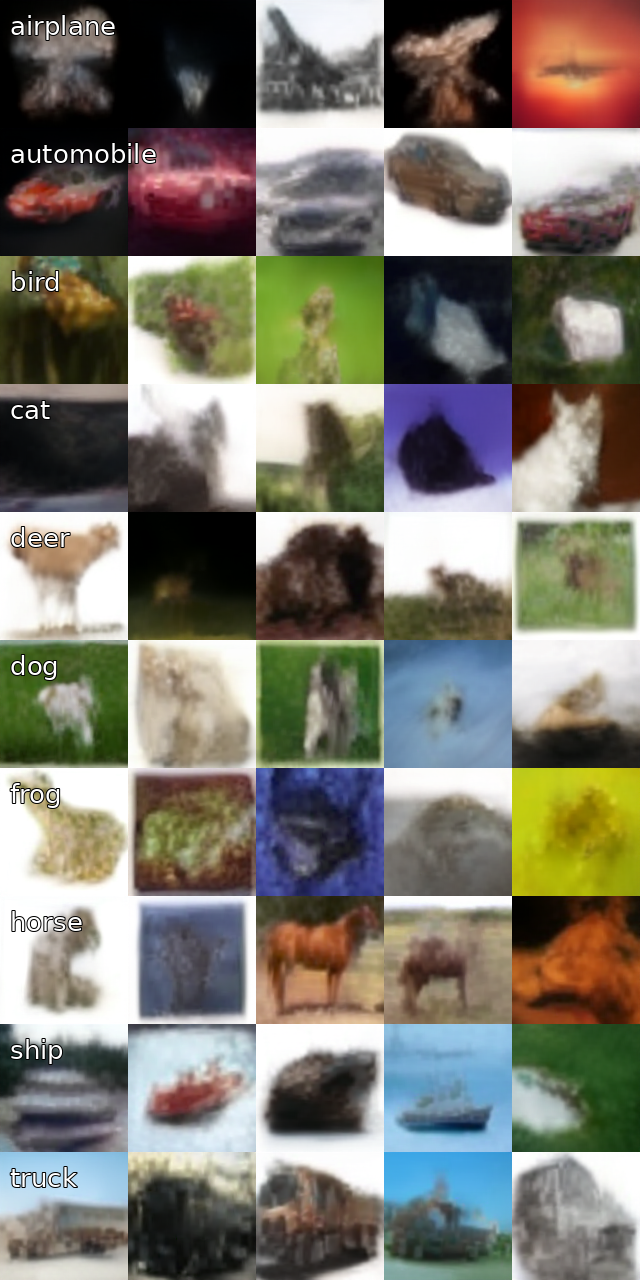

In [5]:
prompts = [cifar10_labels[k] for k in cifar10_labels]
num_imgs_per_label = 5
images = []
for prompt in tqdm(prompts):
    images_prompt = [
        generate(prompt, tokenizer, text_encoder, latent_dim=[1, 32, 4, 4], num_steps=100)
        for _ in range(num_imgs_per_label)
    ]
    images_prompt = make_grid(images_prompt, 1, num_imgs_per_label)
    images_prompt = pil_add_text(images_prompt, prompt, stroke_width=1, stroke_fill=(0,0,0), position = (10, 10))
    images.append(images_prompt)
make_grid(images, len(prompts), 1)